In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
colab = True

if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Tesis/tesis/generative')
else:
    os.chdir('../generative')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import argparse
import json
import models
import training_loss

import torch
from dataset_manager import GenerativeAIDataset
from torch.utils.data import DataLoader

from transformation.data_preprocessing import get_data_composing

from tqdm import tqdm

In [4]:
### Parametros del script
from collections import namedtuple

Args = namedtuple('Args', [
    'batch_size',
    'learning_rate',
    'max_epochs',
    'model',
    'config'
])

args = Args(
    batch_size=8,
    learning_rate=1e-3,
    max_epochs=350,
    model='DIFFUSION',
    config='./config.json')

In [5]:
with open(args.config, 'r') as f:
    config = json.load(f)

device = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = args.batch_size
model_name = args.model
lr = args.learning_rate

sr = config['audio_config']['sample_rate']

In [12]:
device

'cuda'

In [6]:
data_processing = get_data_composing(model_name, config)
train_dataset = GenerativeAIDataset('../data/train_gen',
                            data_processing,
                            class_c='BOAFAB',
                            expand_data=1)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True, shuffle=True)


In [ ]:
# import matplotlib.pyplot as plt
# import librosa
# import numpy as np
# from IPython.display import Audio

# h = next(iter(train_dataloader))['samples'].numpy()[15][0]
# plt.figure().set_figwidth(12)
# librosa.display.waveshow(h, sr=sr)
# # Perform a Short-Time Fourier Transform (STFT)
# D = librosa.stft(h)
# # Convert the complex-valued result to magnitude
# S_db = librosa.amplitude_to_db(abs(D), ref=np.max)
# # Display the spectrogram
# plt.figure(figsize=(14, 5))
# librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
# # plt.colorbar(format='%+2.0f dB')
# plt.title('Espectrograma de Frecuencia Real')
# plt.show()
# Audio(data=h, rate=sr)

In [ ]:
torch.cuda.empty_cache()

In [7]:
model = models.create_model(model_name, config=config).to(device)
training_loss_function = training_loss.get_loss_train(model_name, general_config=config)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1)


In [8]:
def train(epoch):

    model.train()  # Set model to training mode (lo dejo si hago validación)

    running_loss = 0.0
    pbar = tqdm(train_dataloader,
            unit="audios",
            unit_scale=train_dataloader.batch_size,
            desc=f'Epoca {epoch}')
    for step, batch in enumerate(pbar):
        batch = batch['samples'].to(device)
        optimizer.zero_grad()
        loss = training_loss_function(model, batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix({
            'loss': "%.05f" % (running_loss / (step + 1))
        })

    loss_epoch = running_loss / len(train_dataloader)

    return loss_epoch

In [9]:
args.max_epochs

350

In [10]:
print(f'Training {model_name}')
# optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
# 250 epocas!!
# 300 al final
for epoch in range(args.max_epochs):

    loss_train = train(epoch)

    lr_scheduler.step(metrics=loss_train)
    if epoch % 5 == 0:
      if model_name == 'VAE':
          path = f'./models_trained/VAE/{model_name}_model.pth'
      else:
          path = f'./models_trained/DIFFUSION/{epoch}_{model_name}_model.pth'

      torch.save(model, path)

torch.save(model, f'{model_name}_model.pth')

print('Model was save')

Training DIFFUSION


Epoca 76:  91%|█████████ | 13288/14656 [14:27<01:29, 15.32audios/s, loss=0.00346]


KeyboardInterrupt: 

In [ ]:
model.eval()

In [ ]:
from sampling.sampling_utils import get_diffusion_sample
import sys
sys.path.append(os.path.abspath("../model_utils"))
from model_utils.diffusion_utils import calc_diffusion_hyperparams

diffusion_config = config['diffusion_config']
diffusion_hyperparams = calc_diffusion_hyperparams(**diffusion_config)
samples = get_diffusion_sample(model, (10, 1, sr), diffusion_hyperparams)

begin sampling, total number of reverse steps = 200


Reverse process: 100%|██████████| 200/200 [00:35<00:00,  5.56it/s]


In [ ]:
samples.shape

torch.Size([10, 1, 16000])

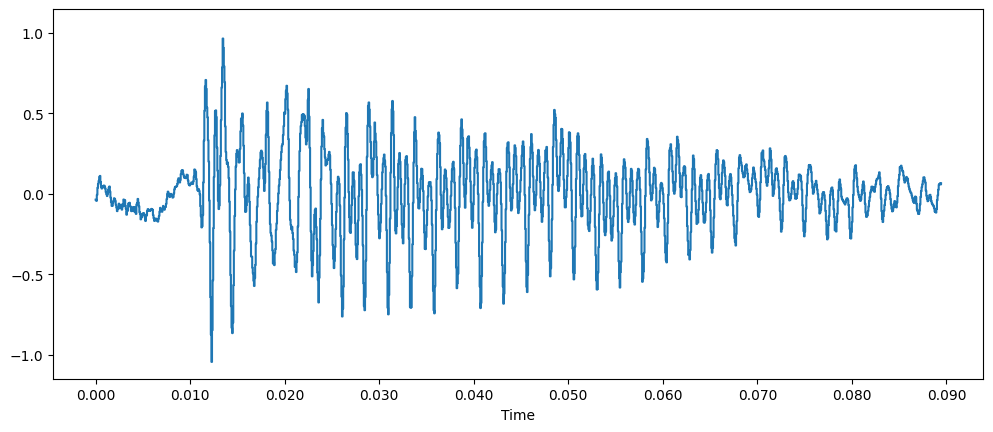

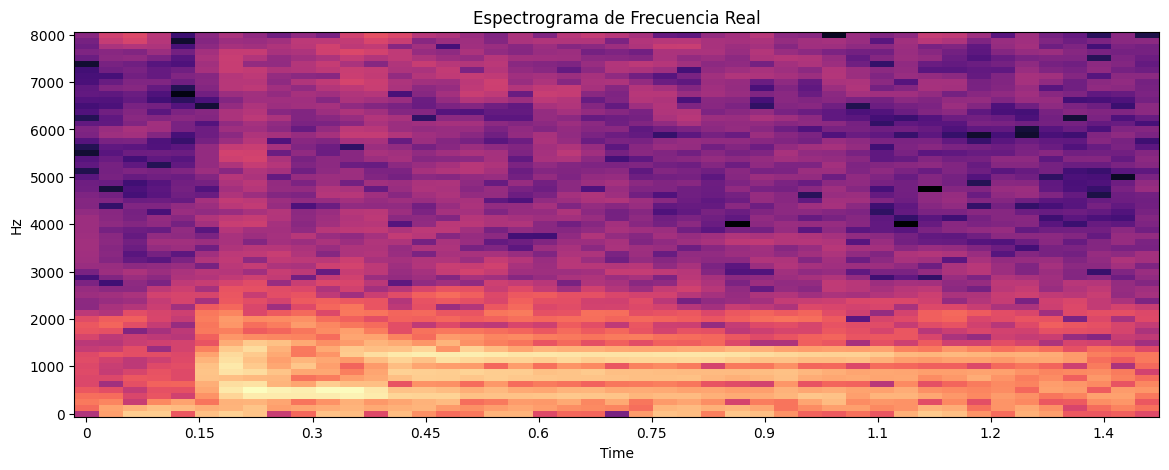

In [ ]:
import matplotlib.pyplot as plt
import librosa
import numpy as np
from IPython.display import Audio

h = samples.cpu().numpy()[0][0][:1432]
plt.figure().set_figwidth(12)
librosa.display.waveshow(h, sr=sr)
# Perform a Short-Time Fourier Transform (STFT)
D = librosa.stft(h,n_fft= 1024//2//2//2)
# Convert the complex-valued result to magnitude
S_db = librosa.amplitude_to_db(abs(D), ref=np.max)
# Display the spectrogram
plt.figure(figsize=(14, 5))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
# plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma de Frecuencia Real')
plt.show()
Audio(data=h, rate=sr)

In [ ]:
1.0348935 + m.bias[0]


tensor(0.8643, grad_fn=<AddBackward0>)